In [54]:
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'use'])
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to C:\Users\Fuzel
[nltk_data]     Shaik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [55]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from tabulate import tabulate
import pyLDAvis
import pyLDAvis.gensim_models as genismnvis 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from gensim import models
import warnings
warnings.filterwarnings('ignore')

In [56]:
topicsname=[]
num_topics =10
bigramDataWords = []
trigramDataWords = []
EvaluationResults =[]
appDetailInputsForLDA =[]
ldaModelDetailsTfAppWise =[]
ldaModelDetailsTfIdfAppWise =[]

#function for preprocessing Data
def PreProcessReviewData(reviewData):
    for review in reviewData:
        yield gensim.utils.simple_preprocess(str(review), deacc=True, min_len=2)  # deacc=True removes punctuations

#function for removing stopwords
def removeStopWords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#function for bigram creation 
def make_bigrams(texts):
    for doc in texts:
        x = bigram_mod[doc]
        bigramDataWords.append(x)
    return bigramDataWords

#function for trigram creation 
def make_trigrams(texts):
    for doc in texts:
        y = trigram_mod[bigram_mod[doc]]
        trigramDataWords.append(y)
    return trigramDataWords

#function for lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#function for training LDA model with Tf corpus
def TrainLdaModelWithTf(corpus, id2word, topics = 10, passes= 10, iterations =50) :
    ldaModel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=topics,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=passes,
                                            alpha='auto',
                                            per_word_topics=True,
                                            iterations=iterations)
    return ldaModel

#function for training LDA model with TfIdf corpus
def TrainLdaModelWithTfIdf(corpus, id2word, topics = 10, passes= 10, iterations =50) :
    ldaModel = gensim.models.LdaMulticore(corpus=corpus,
                                            id2word=id2word,
                                            num_topics= topics,
                                            random_state=100,
                                            chunksize=100,
                                            passes=passes,
                                            per_word_topics=True,
                                            iterations= iterations)
    return ldaModel

#function for evaluate LDA model
def EvaluatePerformance(corpus, ldaModel, corpusType):
    results =[corpusType]
    perplexity = ldaModel.log_perplexity(corpus)

    # Compute CV Coherence Score
    cvCoherenceModel = CoherenceModel(model=ldaModel, texts=lemmatizedData, dictionary=id2word, coherence='c_v')
    cvCoherence = cvCoherenceModel.get_coherence()

    # Compute umass Coherence Score
    uMassCoherenceModel = CoherenceModel(model=ldaModel, texts=lemmatizedData, dictionary=id2word, coherence='u_mass')
    uMassCoherence = uMassCoherenceModel.get_coherence()

    results.append(perplexity)
    results.append(cvCoherence)
    results.append(uMassCoherence)

    return results

#function for printing words in the topic
def PrintTopicWords(wordSet):
    topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in wordSet]
    for topic,words in topics_words:
        print(str(topic)+ "::"+ str(words))

#function for plpting LDA model generated topics
def PlottingResults(ldamodel, corpus, id2word):
    pyLDAvis.enable_notebook()
    vis = genismnvis.prepare(ldamodel, corpus, id2word)
    return vis

In [97]:
apps = ['C:\\Users\\Fuzel Shaik\\Documents\\Master Thesis\\Data_extraction\\fi\\emergency_sentiment.csv','C:\\Users\\Fuzel Shaik\\Documents\\Master Thesis\\Data_extraction\\fi\\suomi_sentiment.csv','C:\\Users\\Fuzel Shaik\\Documents\\Master Thesis\\Data_extraction\\se\\sos_sentiment.csv','C:\\Users\\Fuzel Shaik\\Documents\\Master Thesis\\Data_extraction\\se\\kinfo_app_sentiment.csv','C:\\Users\\Fuzel Shaik\\Documents\\Master Thesis\\Data_extraction\\no\\hjelp_113_sentiment.csv']

df_emp = pd.read_csv(apps[0])
df_emp['app_name'] = ['emp' for _ in range(0,df_emp.shape[0])]

df_suomi = pd.read_csv(apps[1])
df_suomi['app_name'] = ['suomi' for _ in range(0,df_suomi.shape[0])]

df_sos = pd.read_csv(apps[2])
df_sos['app_name'] = ['sos' for _ in range(0,df_sos.shape[0])]

df_kinfo = pd.read_csv(apps[3])
df_kinfo['app_name'] = ['kinfo' for _ in range(0,df_kinfo.shape[0])]

df_hjelp = pd.read_csv(apps[4])
df_hjelp['app_name'] = ['hjelp' for _ in range(0,df_hjelp.shape[0])]

cmp_df = pd.concat([df_emp,df_suomi,df_sos,df_kinfo,df_hjelp])
cmp_df.to_csv('complete_data_v2.csv',index=False)

In [58]:
apps = [cmp_df]

for i in range(len(apps)):
    EvaluationResults =[]
    df = apps[i].copy()
    reviewDataList = df['Review'].values.tolist()

  #preprocessing using genism simple pre process
    reviewDataWords = list(PreProcessReviewData(reviewDataList))

  #stopword removal using nltk stop words
    reviewDataWordsWithoutStopWords = removeStopWords(reviewDataWords)

  # bigram trigram models
    bigram = gensim.models.Phrases(reviewDataWords, min_count=5, threshold=100)
    trigram = gensim.models.Phrases(bigram[reviewDataWords], threshold=100)

    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
  
  #creating bigram trigram models from the data set
    dataWordsWithbigrams = make_bigrams(reviewDataWordsWithoutStopWords)
    dataWordsWithTrigrams = make_trigrams(dataWordsWithbigrams)

  #lemmatizing data set
    lemmatizedData = lemmatization(dataWordsWithTrigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
 
  #create dictionary as the input for lda model
    id2word = corpora.Dictionary(lemmatizedData)
    
    # Create Corpus
    texts = lemmatizedData

  # create corpus with Term Document Frequency
    corpusTf = [id2word.doc2bow(text) for text in texts]

  #create corpus with tf-idf
    tfidf = gensim.models.TfidfModel(corpusTf)
    corpusTfidf = tfidf[corpusTf]
  
  #store details in dictionary for use later for evaluation
    dictionary = {'appName':apps[i],'id2word':id2word, 'lemmatized': lemmatizedData, 'tf' : corpusTf, 'tfIdf': corpusTfidf }
    appDetailInputsForLDA.append(dictionary)

    ldaModelTfIdfDetails =[]
    
    ldaModelTfIdf = TrainLdaModelWithTfIdf(corpusTfidf, id2word)
    ldaModelTIdffWords = ldaModelTfIdf.show_topics(num_topics=10, num_words=10,formatted=False)
    print("\n 10 Topics obtained from the reviews of "+str(i)+ " - TfIdf Corpus")
    PrintTopicWords(ldaModelTIdffWords) #Fig. 6 in report displays this result
  #pprint(ldaModelTfIdf.print_topics()) -print with probabilities
    results = EvaluatePerformance(corpusTfidf, ldaModelTfIdf, corpusType = 'TF-IDF')
    EvaluationResults.append(results)
  
  #Store details to utilize when plotting graphs
    ldaModelTfIdfDetails.append(ldaModelTfIdf)
    ldaModelTfIdfDetails.append(corpusTfidf)
    ldaModelTfIdfDetails.append(id2word)
    ldaModelDetailsTfIdfAppWise.append(ldaModelTfIdfDetails)
    print('Evaluation table '+str(i)+'------------')
    print (tabulate(EvaluationResults, headers=["Corpus Type", "Perplexity", "Cv coherence score", "U mass Coherence score"]))


 10 Topics obtained from the reviews of 0 - TfIdf Corpus
0::['great', 'app', 'need', 'yet', 'function', 'would', 'highly', 'easy', 'security', 'recommended']
1::['know', 'help', 'need', 'least', 'appear', 'boot', 'sort', 'good', 'allow', 'default']
2::['work', 'crash', 'notification', 'useful', 'good', 'really', 'help', 'safe', 'error', 'app']
3::['update', 'open', 'last', 'app', 'work', 'trip', 'call', 'close', 'situation', 'thing']
4::['address', 'number', 'app', 'find', 'position', 'iphone', 'wrong', 'street', 'enter', 'work']
5::['never', 'easy', 'say', 'hope', 'wait', 'need', 'startup', 'good', 'uninstall', 'soon']
6::['phone', 'open', 'time', 'app', 'call', 'crash', 'oneplus', 'work', 'battery', 'try']
7::['select', 'awesome', 'location', 'press', 'county', 'mode', 'occur', 'seem', 'service', 'app']
8::['good', 'support', 'totally', 'app', 'recommend', 'emergency', 'coverage', 'idea', 'brilliant', 'cause']
9::['important', 'absolutely', 'necessary', 'version', 'app', 'happen', '

In [59]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True,
                                            iterations=50)
                                            
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [60]:
def PlotCoherenceValueAgainstNumofTopics(appName, model, coherence_values):
    limit=40; start=2; step=6;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.title(appName)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score "+ model)
    plt.legend(("coherence_values"), loc='best')
    plt.show()

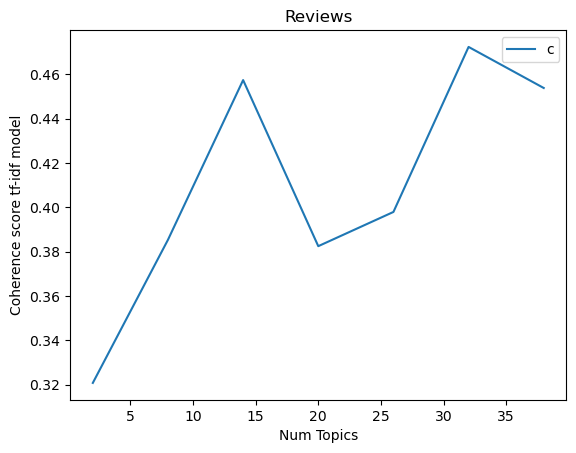

In [61]:
model_list, coherence_values = compute_coherence_values(dictionary=appDetailInputsForLDA[0]['id2word'], corpus=appDetailInputsForLDA[0]['tfIdf'], texts=appDetailInputsForLDA[0]['lemmatized'], start=2, limit=40, step=6)
PlotCoherenceValueAgainstNumofTopics("Reviews", "tf-idf model", coherence_values)

In [62]:
topicsname=[]
bigramDataWords = []
trigramDataWords = []
EvaluationResults =[]
appDetailInputsForLDA =[]
ldaModelDetailsTfAppWise =[]
ldaModelDetailsTfIdfAppWise =[]

In [63]:
apps = [df]

for i in range(len(apps)):
    EvaluationResults =[]
    df = apps[i].copy()
    reviewDataList = df['Review'].values.tolist()
    
    numberofTfIdfTopics=8

  #preprocessing using genism simple pre process
    reviewDataWords = list(PreProcessReviewData(reviewDataList))

  #stopword removal using nltk stop words
    reviewDataWordsWithoutStopWords = removeStopWords(reviewDataWords)

  # bigram trigram models
    bigram = gensim.models.Phrases(reviewDataWords, min_count=5, threshold=100)
    trigram = gensim.models.Phrases(bigram[reviewDataWords], threshold=100)

    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
  
  #creating bigram trigram models from the data set
    dataWordsWithbigrams = make_bigrams(reviewDataWordsWithoutStopWords)
    dataWordsWithTrigrams = make_trigrams(dataWordsWithbigrams)

  #lemmatizing data set
    lemmatizedData = lemmatization(dataWordsWithTrigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
 
  #create dictionary as the input for lda model
    id2word = corpora.Dictionary(lemmatizedData)
    
    # Create Corpus
    texts = lemmatizedData

  # create corpus with Term Document Frequency
    corpusTf = [id2word.doc2bow(text) for text in texts]

  #create corpus with tf-idf
    tfidf = gensim.models.TfidfModel(corpusTf)
    corpusTfidf = tfidf[corpusTf]
  
  #store details in dictionary for use later for evaluation
    dictionary = {'appName':apps[i],'id2word':id2word, 'lemmatized': lemmatizedData, 'tf' : corpusTf, 'tfIdf': corpusTfidf }
    appDetailInputsForLDA.append(dictionary)

    ldaModelTfIdfDetails =[]
    
    ldaModelTfIdf = TrainLdaModelWithTfIdf(corpusTfidf, id2word, topics=numberofTfIdfTopics, passes=20)
    ldaModelTIdffWords = ldaModelTfIdf.show_topics(num_topics=numberofTfIdfTopics, num_words=10,formatted=False)
    print("\nTopics obtained from the reviews of "+str(i)+ " - TfIdf Corpus")
    PrintTopicWords(ldaModelTIdffWords) #Fig. 6 in report displays this result
  #pprint(ldaModelTfIdf.print_topics()) -print with probabilities
    results = EvaluatePerformance(corpusTfidf, ldaModelTfIdf, corpusType = 'TF-IDF')
    EvaluationResults.append(results)
  
  #Store details to utilize when plotting graphs
    ldaModelTfIdfDetails.append(ldaModelTfIdf)
    ldaModelTfIdfDetails.append(corpusTfidf)
    ldaModelTfIdfDetails.append(id2word)
    ldaModelDetailsTfIdfAppWise.append(ldaModelTfIdfDetails)
    print (tabulate(EvaluationResults, headers=["Corpus Type", "Perplexity", "Cv coherence score", "U mass Coherence score"]))


Topics obtained from the reviews of 0 - TfIdf Corpus
0::['great', 'app', 'iphone', 'would', 'work', 'well', 'nice', 'idea', 'function', 'need']
1::['yet', 'position', 'good', 'find', 'location', 'know', 'app', 'call', 'need', 'always']
2::['good', 'app', 'help', 'useful', 'support', 'really', 'trip', 'move', 'safe', 'county']
3::['important', 'last', 'update', 'absolutely', 'easy', 'open', 'app', 'great', 'save_live', 'work']
4::['work', 'necessary', 'recommend', 'excellent', 'mode', 'wrong', 'regard', 'address', 'dark', 'sneaky']
5::['notification', 'work', 'app', 'battery', 'say', 'phone', 'program', 'want', 'save', 'call']
6::['open', 'crash', 'phone', 'time', 'update', 'immediately', 'app', 'work', 'number', 'oneplus']
7::['never', 'need', 'emergency', 'awesome', 'event', 'bad', 'cause', 'number', 'accident', 'download']
Corpus Type      Perplexity    Cv coherence score    U mass Coherence score
-------------  ------------  --------------------  ------------------------
TF-IDF    

In [ ]:
ldaModelTfIdf.save('lda.model')

In [46]:
model=models.LdaModel.load('lda.model')

In [64]:
vis =PlottingResults(ldaModelDetailsTfIdfAppWise[0][0], ldaModelDetailsTfIdfAppWise[0][1], ldaModelDetailsTfIdfAppWise[0][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.127475 -0.061415       1        1  21.354706
1      0.112365 -0.007073       2        1  15.948805
6      0.027054  0.000124       3        1  14.095707
0     -0.008332 -0.045206       4        1  13.445270
2     -0.061138  0.116377       5        1   9.776619
7      0.001647  0.123440       6        1   9.578879
4     -0.068738 -0.021085       7        1   7.904767
3     -0.130334 -0.105162       8        1   7.895248, topic_info=          Term       Freq      Total Category  logprob  loglift
7         good  98.000000  98.000000  Default  30.0000  30.0000
374  important  31.000000  31.000000  Default  29.0000  29.0000
207       open  45.000000  45.000000  Default  28.0000  28.0000
19       never  30.000000  30.000000  Default  27.0000  27.0000
96        last  25.000000  25.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
0      address   4.111536  30.202941   Topic8  -5.0258   0.5448
18        need   4.243261  47.628632   Topic8  -4.9942   0.1208
218     useful   3.404182  20.203195   Topic8  -5.2145   0.7581
272     really   3.513091  31.023291   Topic8  -5.1831   0.3607
256      start   3.197179  23.620203   Topic8  -5.2773   0.5391

[481 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
58        1  0.230472      able
58        2  0.537767      able
58        3  0.076824      able
58        5  0.153648      able
3051      4  0.655881  absolute
...     ...       ...       ...
26        7  0.416463     wrong
87        1  0.233333      year
87        3  0.583332      year
87        4  0.116666      year
78        2  0.932801       yet

[857 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 7, 1, 3, 8, 5, 4])

In [65]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [100]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldaModelTfIdf, corpus=corpusTfidf, texts=lemmatizedData)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7,0.6771,"never, need, emergency, awesome, event, bad, c...","[latitude, longitude, correct, notice, address..."
1,1,4,0.6788,"work, necessary, recommend, excellent, mode, w...","[show, wrong, address]"
2,2,0,0.5624,"great, app, iphone, would, work, well, nice, i...",[must]
3,3,4,0.5625,"work, necessary, recommend, excellent, mode, w...",[excellent]
4,4,1,0.4275,"yet, position, good, find, location, know, app...","[set, address, incorrectly, marker, clearly, p..."
5,5,2,0.5914,"good, app, help, useful, support, really, trip...","[location, truncate, read, rely, app, real, em..."
6,6,1,0.4836,"yet, position, good, find, location, know, app...","[old, hit, info, message, device, compatible, ..."
7,7,4,0.6261,"work, necessary, recommend, excellent, mode, w...","[location, wrong, let, adjust, set, home, loca..."
8,8,1,0.6791,"yet, position, good, find, location, know, app...","[location, always, wrong, location]"
9,9,4,0.7397,"work, necessary, recommend, excellent, mode, w...","[give, incorrect, street, number, emergency, v..."


In [101]:
df_dominant_topic['senti'] = cmp_df['Sentiment'].to_list()
df_dominant_topic['app_name'] = cmp_df['app_name'].to_list()

In [102]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,senti,app_name
0,0,7,0.6771,"never, need, emergency, awesome, event, bad, c...","[latitude, longitude, correct, notice, address...",1,emp
1,1,4,0.6788,"work, necessary, recommend, excellent, mode, w...","[show, wrong, address]",-1,emp
2,2,0,0.5624,"great, app, iphone, would, work, well, nice, i...",[must],1,emp
3,3,4,0.5625,"work, necessary, recommend, excellent, mode, w...",[excellent],1,emp
4,4,1,0.4275,"yet, position, good, find, location, know, app...","[set, address, incorrectly, marker, clearly, p...",1,emp


Topic 1: Device compatability
Topic 2: Information transforability
Topic 3: Application functionality
Topic 4: User's satisfaction
Topic 5: Application necessity
Topic 6: Application usability
Topic 7: Application reliability
Topic 8: User's trustworthiness

df_dominant_topic['Dominant_Topic_name'] = df_dominant_topic['Dominant_Topic'].replace([0,1,2,3,4,5,6,7],['Device compatability','Information transforability','Application functionality',"User's satisfaction",'Application necessity','Application usability','Application reliability',"User's trustworthiness"])

df_dominant_topic.head()

df_dominant_topic.to_csv('topic_named_data.csv',index=False)

In [104]:
df_dominant_topic[df_dominant_topic['senti']==1]['Dominant_Topic'].value_counts()

5    328
2    287
0    285
1    201
6    167
7    126
3    123
4    104
Name: Dominant_Topic, dtype: int64

<BarContainer object of 8 artists>

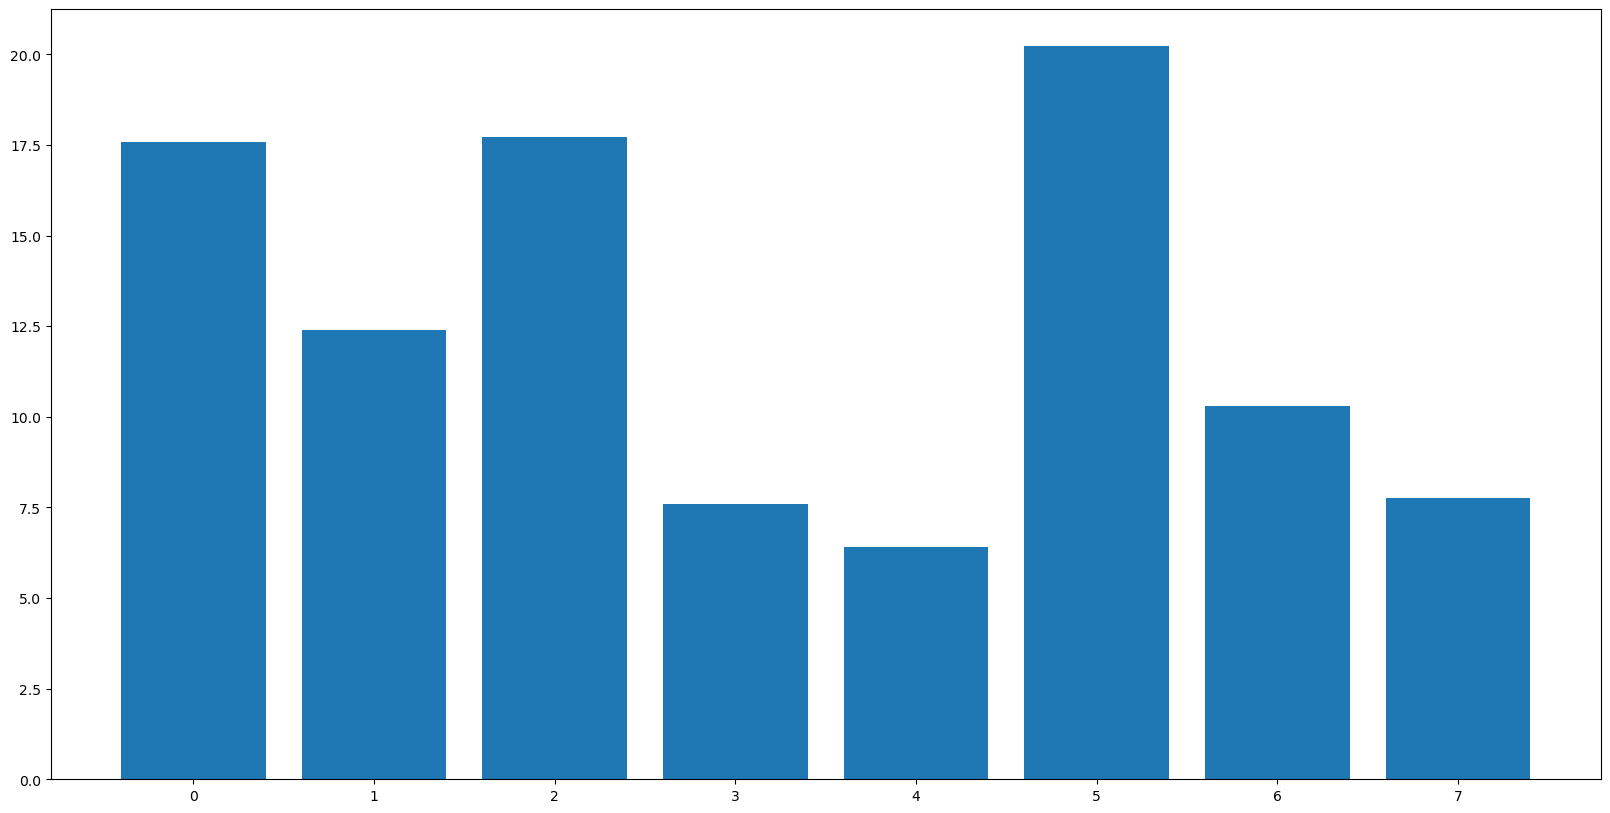

In [105]:
temp_df = pd.DataFrame(df_dominant_topic[df_dominant_topic['senti']==1]['Dominant_Topic'].value_counts()).reset_index()
temp_df.columns = ['Dominant_Topic','Frequency']
temp_df['dominant_topic_percentage'] = round((temp_df['Frequency']/temp_df['Frequency'].sum())*100,2)
plt.figure(figsize=(20,10))
plt.bar(temp_df['Dominant_Topic'],temp_df['dominant_topic_percentage'])

In [106]:
temp_df

,Dominant_Topic,Frequency,dominant_topic_percentage
0,5,328,20.23
1,2,287,17.71
2,0,285,17.58
3,1,201,12.40
4,6,167,10.30
5,7,126,7.77
6,3,123,7.59
7,4,104,6.42


In [107]:
df_dominant_topic[df_dominant_topic['senti']==-1]['Dominant_Topic'].value_counts()

5    228
1    144
6    137
0    118
7     98
4     48
2     44
3     43
Name: Dominant_Topic, dtype: int64

<BarContainer object of 8 artists>

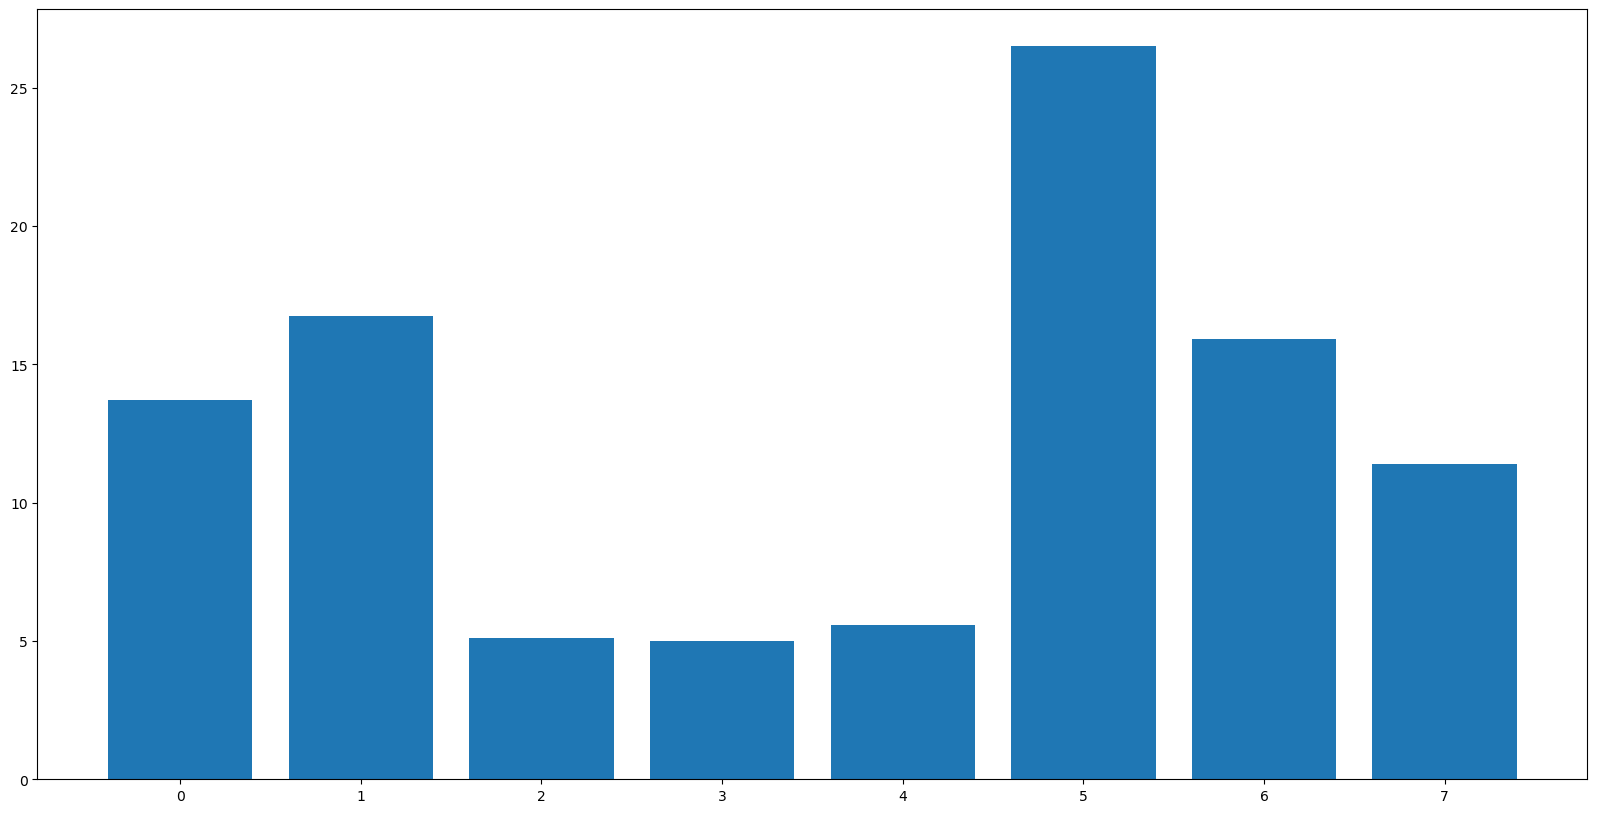

In [108]:
temp_df = pd.DataFrame(df_dominant_topic[df_dominant_topic['senti']==-1]['Dominant_Topic'].value_counts()).reset_index()
temp_df.columns = ['Dominant_Topic','Frequency']
temp_df['dominant_topic_percentage'] = round((temp_df['Frequency']/temp_df['Frequency'].sum())*100,2)
plt.figure(figsize=(20,10))
plt.bar(temp_df['Dominant_Topic'],temp_df['dominant_topic_percentage'])

In [109]:
temp_df

,Dominant_Topic,Frequency,dominant_topic_percentage
0,5,228,26.51
1,1,144,16.74
2,6,137,15.93
3,0,118,13.72
4,7,98,11.40
5,4,48,5.58
6,2,44,5.12
7,3,43,5.00


In [110]:
d_pos = {}

In [111]:
for topic in list(df_dominant_topic['Dominant_Topic'].unique()):
    number_of_reviews_for_positive_sentiment = df_dominant_topic[df_dominant_topic['senti']==1].shape[0]
    number_of_total_reviews = cmp_df.shape[0]
    prob_review_belongs_topic_2_pos_reviews = df_dominant_topic[(df_dominant_topic['senti']==1) & (df_dominant_topic['Dominant_Topic']==topic)].shape[0]
    prob_review_belongs_topic_2_whole_reviews = df_dominant_topic[df_dominant_topic['Dominant_Topic']==topic].shape[0]
    topic_score_pos_reviews = ((1/number_of_reviews_for_positive_sentiment)*prob_review_belongs_topic_2_pos_reviews)/((1/number_of_total_reviews)*prob_review_belongs_topic_2_whole_reviews)
    d_pos[topic] = round(topic_score_pos_reviews,2)

In [112]:
d_pos

{7: 0.9, 4: 0.94, 0: 1.0, 1: 0.9, 2: 1.56, 5: 0.93, 6: 0.78, 3: 1.13}

In [113]:
d_neg = {}

In [114]:
for topic in list(df_dominant_topic['Dominant_Topic'].unique()):
    number_of_reviews_for_negative_sentiment = df_dominant_topic[df_dominant_topic['senti']==-1].shape[0]
    number_of_total_reviews = cmp_df.shape[0]
    prob_review_belongs_topic_2_neg_reviews = df_dominant_topic[(df_dominant_topic['senti']==-1) & (df_dominant_topic['Dominant_Topic']==topic)].shape[0]
    prob_review_belongs_topic_2_whole_reviews = df_dominant_topic[df_dominant_topic['Dominant_Topic']==topic].shape[0]
    topic_score_pos_reviews = ((1/number_of_reviews_for_negative_sentiment)*prob_review_belongs_topic_2_neg_reviews)/((1/number_of_total_reviews)*prob_review_belongs_topic_2_whole_reviews)
    d_neg[topic] = round(topic_score_pos_reviews,2)

In [115]:
d_neg

{7: 1.32, 4: 0.82, 0: 0.78, 1: 1.21, 2: 0.45, 5: 1.21, 6: 1.21, 3: 0.75}

In [116]:
topic_score_df = pd.DataFrame(d_pos.keys())

In [117]:
topic_score_df['topic_score_pos_reviews'] = d_pos.values()

In [118]:
topic_score_df['topic_score_neg_reviews'] = d_neg.values()

In [119]:
topic_score_df.columns = ['Topics','Topic score for positive sentiment','Topic score for negative sentiment']
topic_score_df['Topics'] = topic_score_df['Topics'].astype('int')
topic_score_df.sort_values('Topics',inplace=True)

<AxesSubplot:title={'center':'Positive vs Negative sentiments'}, xlabel='Topics'>

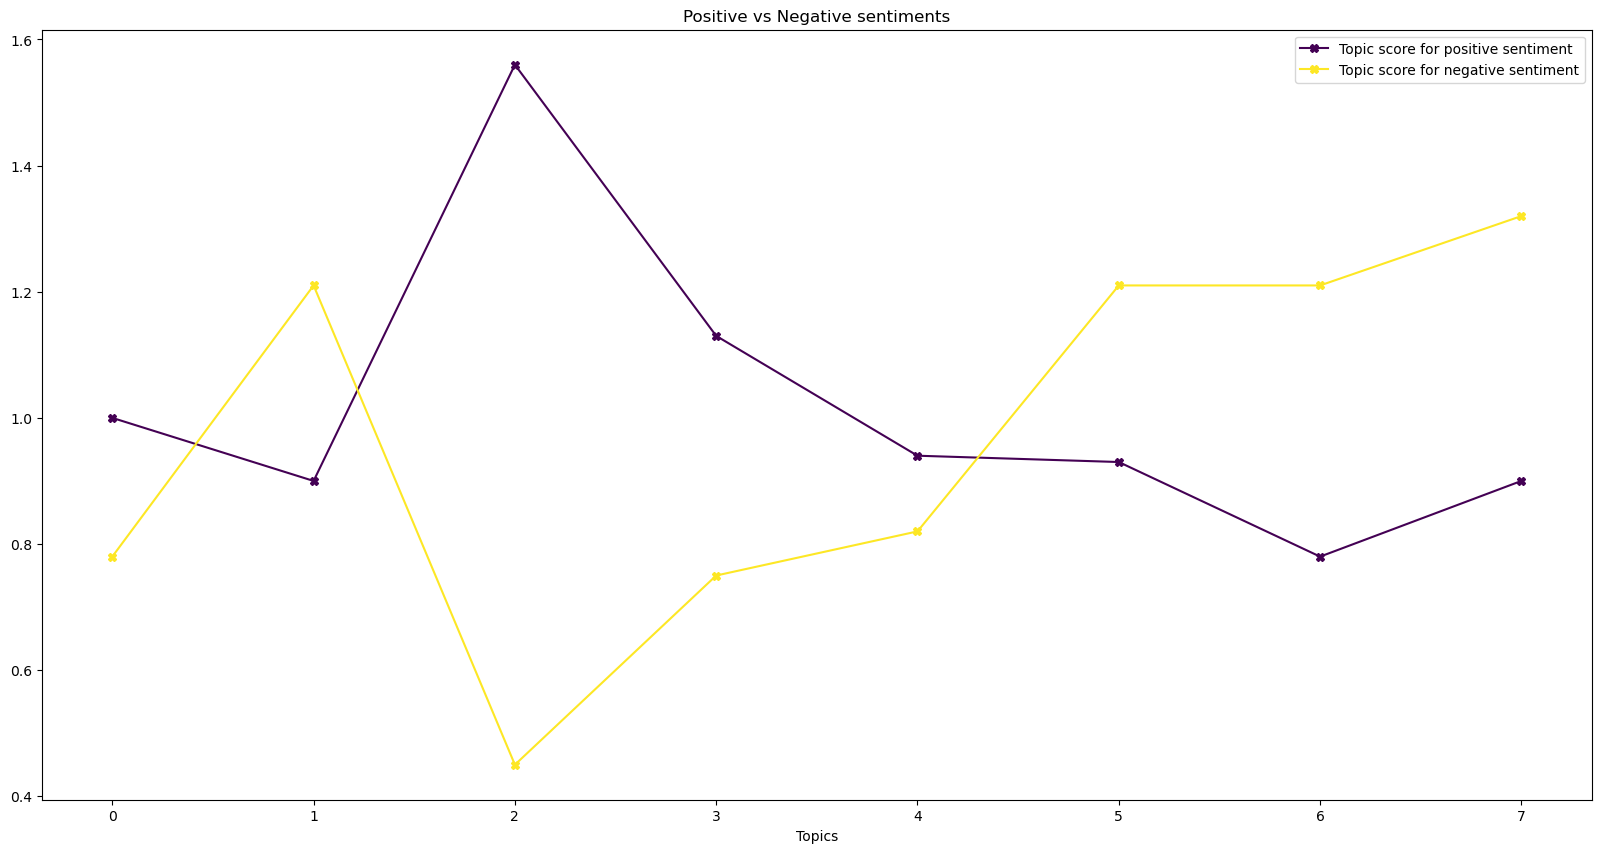

In [120]:
topic_score_df.plot(x='Topics', title = 'Positive vs Negative sentiments',colormap = 'viridis',figsize=(20,10), marker='X')

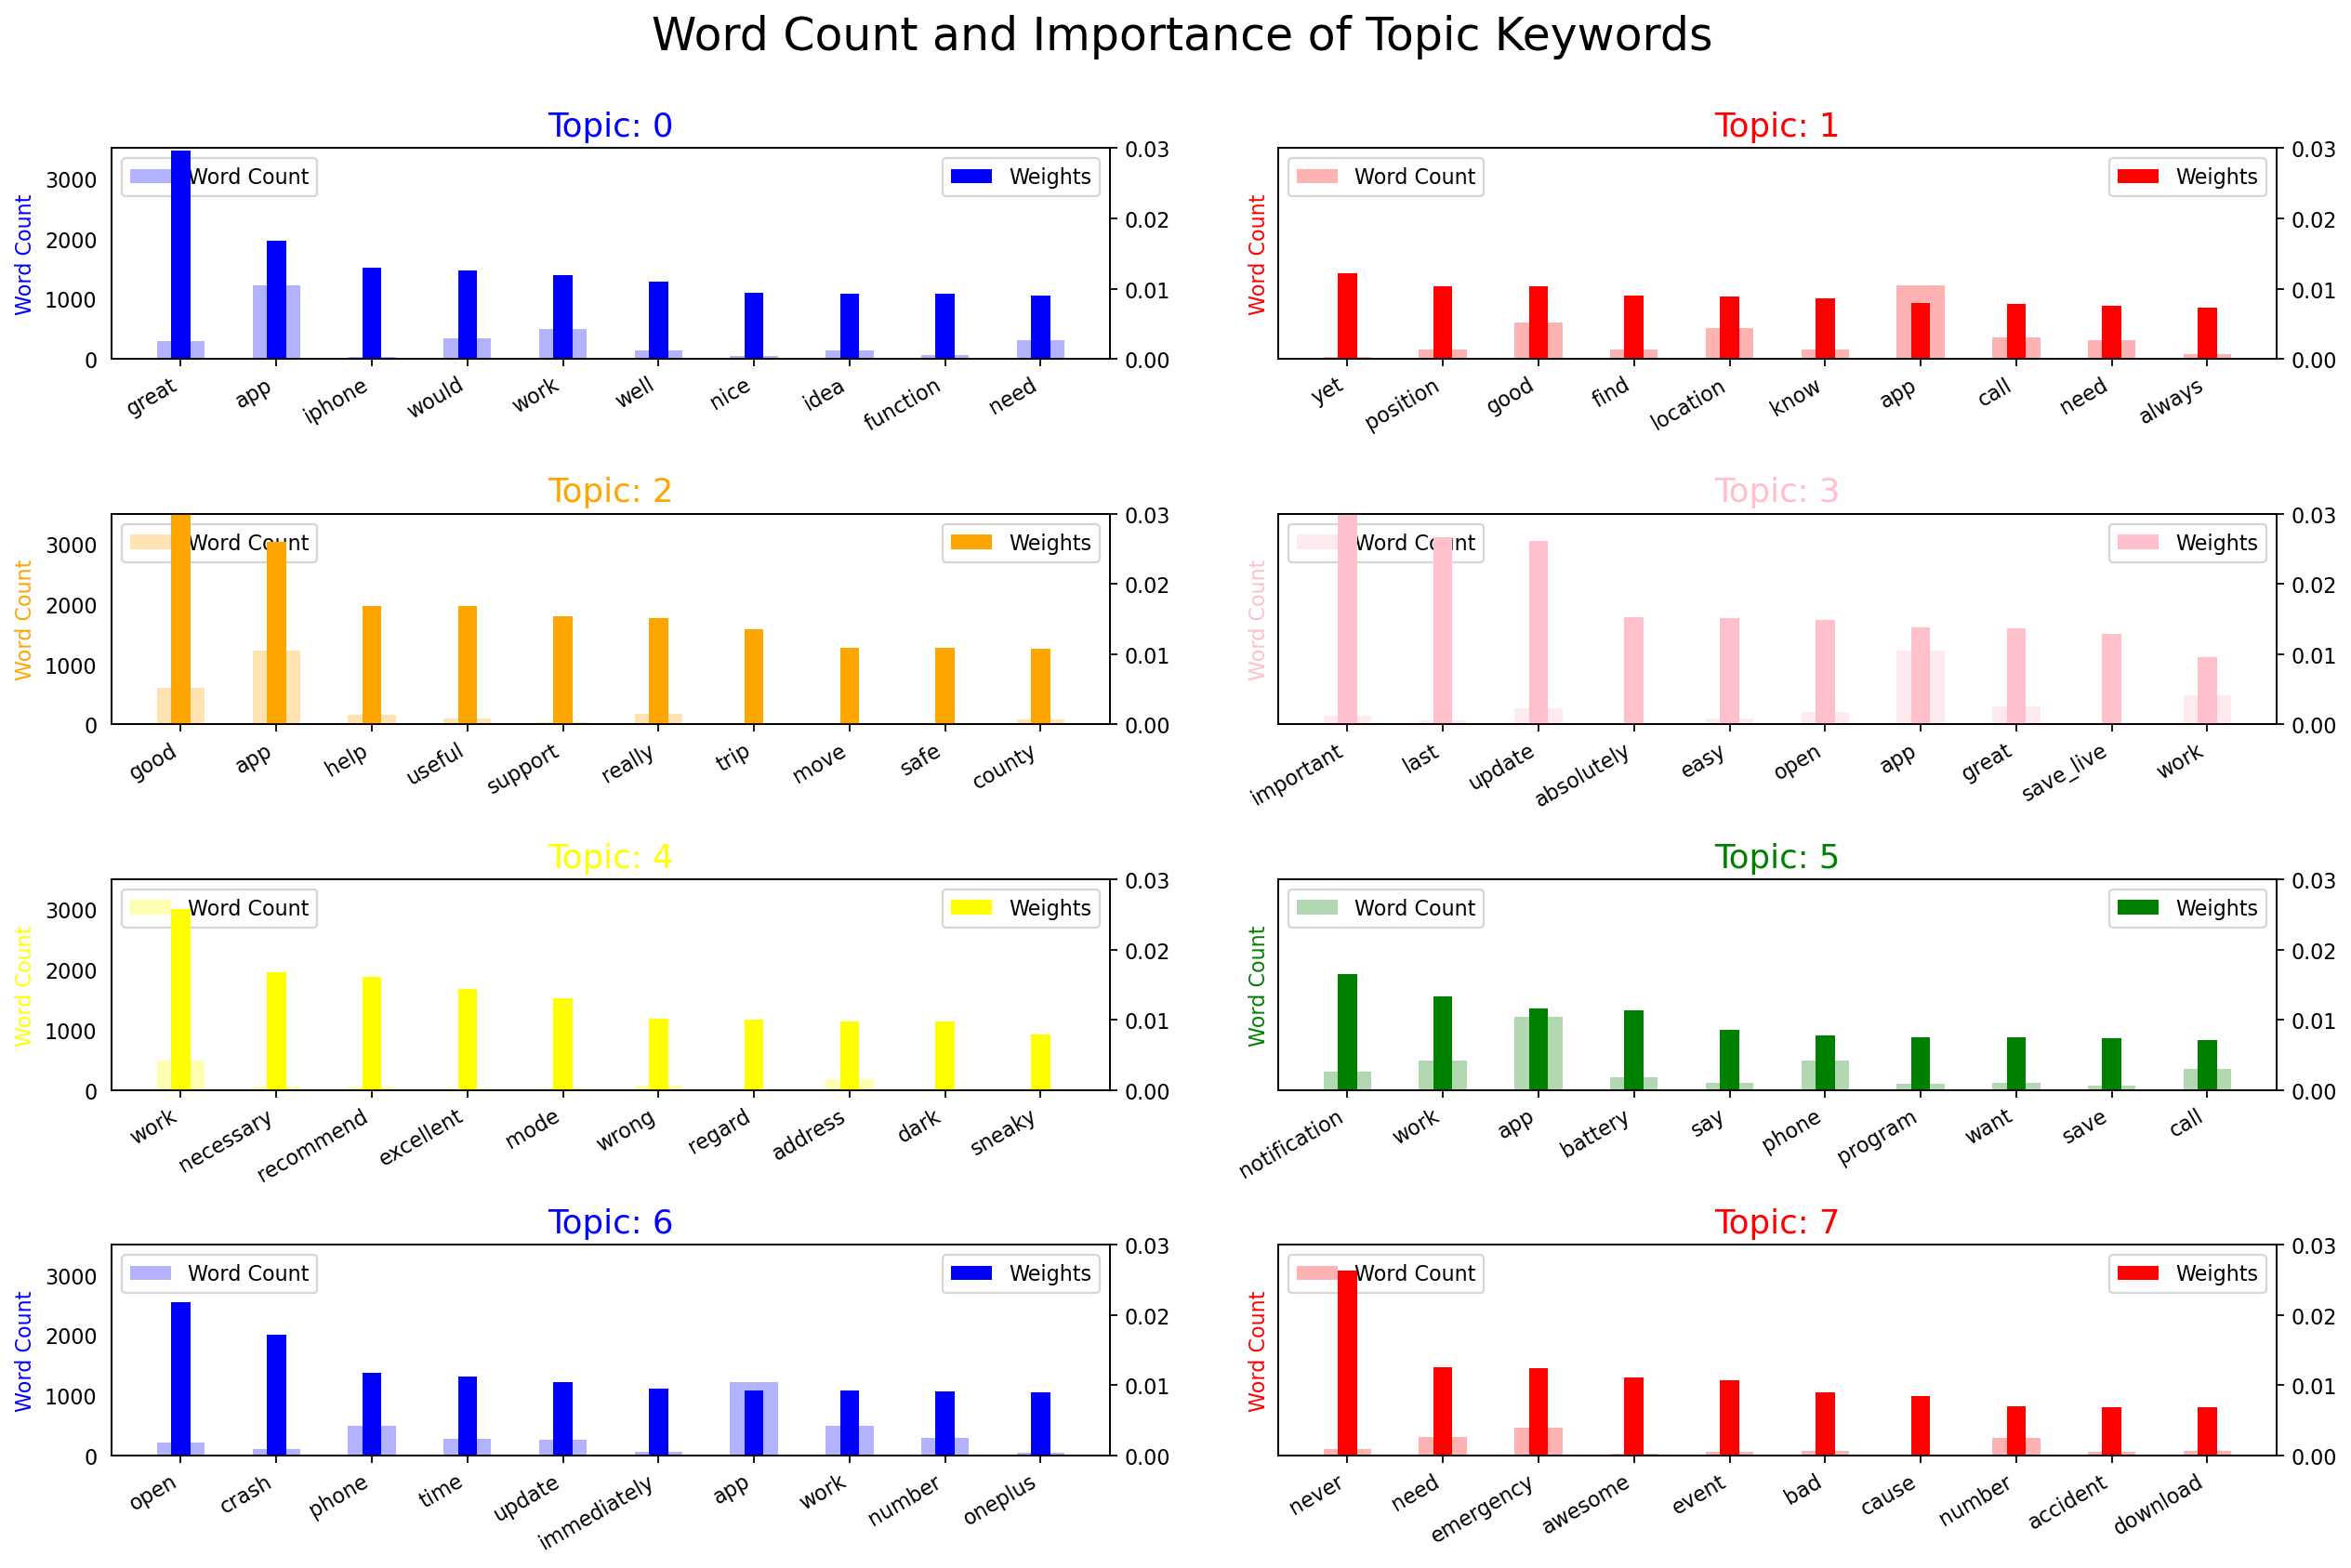

In [121]:
from collections import Counter
topics = ldaModelTfIdf.show_topics(formatted=False)
data_flat = [w for w_list in lemmatizedData for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(16,10), sharey=True, dpi=160)
cols = ['blue','red','orange','pink','yellow','green','blue','red','red','orange','pink','yellow','green','blue','red']
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [94]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=ldaModelTfIdf, corpus=corpusTfidf, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in ldaModelTfIdf.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

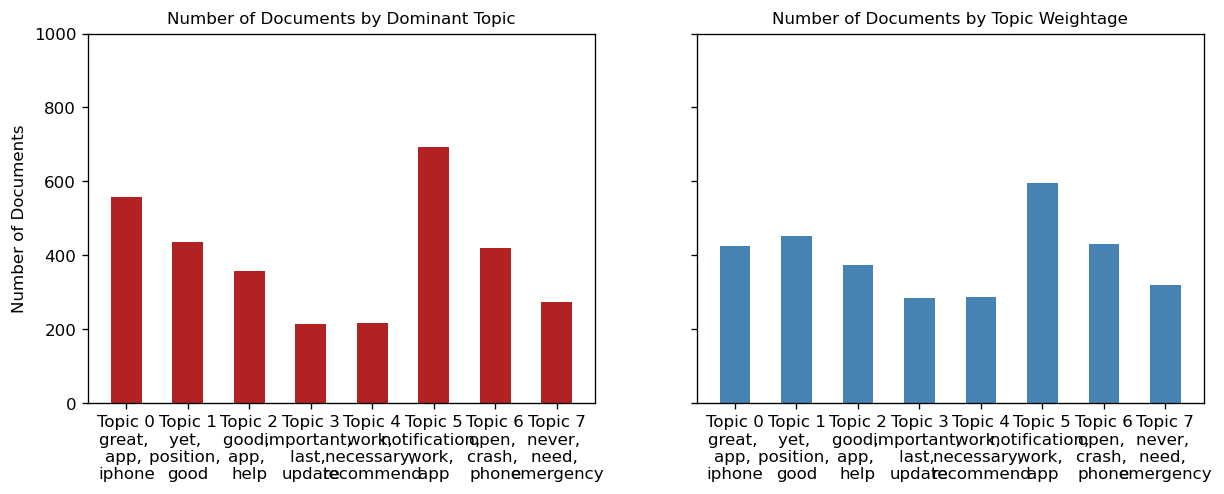

In [95]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

## Dominant topics positive sentiment

In [127]:
pos_senti_df = df_dominant_topic[df_dominant_topic['senti']==1]

In [129]:
pos_senti_df['app_name'].value_counts()

suomi    724
emp      540
sos      206
hjelp     76
kinfo     75
Name: app_name, dtype: int64

In [130]:
d_suomi = {}
for topic in list(pos_senti_df['Dominant_Topic'].unique()):
    number_of_reviews_for_suomi = pos_senti_df[pos_senti_df['app_name']=='suomi'].shape[0]
    number_of_total_reviews = pos_senti_df.shape[0]
    prob_of_topic_suomi = pos_senti_df[(pos_senti_df['app_name']=='suomi') & (pos_senti_df['Dominant_Topic']==topic)].shape[0]
    prob_of_topic_whole = pos_senti_df[pos_senti_df['Dominant_Topic']==topic].shape[0]
    suomi_topic_scores = ((1/number_of_reviews_for_suomi)*prob_of_topic_suomi)/((1/number_of_total_reviews)*prob_of_topic_whole)
    d_suomi[topic] = round(suomi_topic_scores,2)
d_suomi

{7: 0.94, 0: 0.91, 4: 0.8, 1: 0.97, 2: 1.47, 6: 0.88, 5: 0.74, 3: 1.26}

In [132]:
d_emp = {}
for topic in list(pos_senti_df['Dominant_Topic'].unique()):
    number_of_reviews_for_emp = pos_senti_df[pos_senti_df['app_name']=='emp'].shape[0]
    number_of_total_reviews = pos_senti_df.shape[0]
    prob_of_topic_emp = pos_senti_df[(pos_senti_df['app_name']=='emp') & (pos_senti_df['Dominant_Topic']==topic)].shape[0]
    prob_of_topic_whole = pos_senti_df[pos_senti_df['Dominant_Topic']==topic].shape[0]
    emp_topic_scores = ((1/number_of_reviews_for_emp)*prob_of_topic_emp)/((1/number_of_total_reviews)*prob_of_topic_whole)
    d_emp[topic] = round(emp_topic_scores,2)
d_emp

{7: 1.14, 0: 1.18, 4: 1.62, 1: 0.82, 2: 0.62, 6: 1.22, 5: 0.99, 3: 0.83}

In [140]:
d_sos = {}
for topic in list(pos_senti_df['Dominant_Topic'].unique()):
    number_of_reviews_for_sos = pos_senti_df[pos_senti_df['app_name']=='sos'].shape[0]
    number_of_total_reviews = pos_senti_df.shape[0]
    prob_of_topic_sos = pos_senti_df[(pos_senti_df['app_name']=='sos') & (pos_senti_df['Dominant_Topic']==topic)].shape[0]
    prob_of_topic_whole = pos_senti_df[pos_senti_df['Dominant_Topic']==topic].shape[0]
    sos_topic_scores = ((1/number_of_reviews_for_sos)*prob_of_topic_sos)/((1/number_of_total_reviews)*prob_of_topic_whole)
    d_sos[topic] = round(suomi_topic_scores,2)
d_sos

{7: 1.26, 0: 1.26, 4: 1.26, 1: 1.26, 2: 1.26, 6: 1.26, 5: 1.26, 3: 1.26}

In [134]:
d_hjelp = {}
for topic in list(pos_senti_df['Dominant_Topic'].unique()):
    number_of_reviews_for_hjelp = pos_senti_df[pos_senti_df['app_name']=='hjelp'].shape[0]
    number_of_total_reviews = pos_senti_df.shape[0]
    prob_of_topic_hjelp = pos_senti_df[(pos_senti_df['app_name']=='hjelp') & (pos_senti_df['Dominant_Topic']==topic)].shape[0]
    prob_of_topic_whole = pos_senti_df[pos_senti_df['Dominant_Topic']==topic].shape[0]
    hjelp_topic_scores = ((1/number_of_reviews_for_hjelp)*prob_of_topic_hjelp)/((1/number_of_total_reviews)*prob_of_topic_whole)
    d_hjelp[topic] = round(hjelp_topic_scores,2)
d_hjelp

{7: 1.35, 0: 0.67, 4: 1.23, 1: 1.38, 2: 0.97, 6: 0.64, 5: 0.78, 3: 1.73}

In [135]:
d_kinfo = {}
for topic in list(pos_senti_df['Dominant_Topic'].unique()):
    number_of_reviews_for_kinfo = pos_senti_df[pos_senti_df['app_name']=='kinfo'].shape[0]
    number_of_total_reviews = pos_senti_df.shape[0]
    prob_of_topic_kinfo = pos_senti_df[(pos_senti_df['app_name']=='kinfo') & (pos_senti_df['Dominant_Topic']==topic)].shape[0]
    prob_of_topic_whole = pos_senti_df[pos_senti_df['Dominant_Topic']==topic].shape[0]
    kinfo_topic_scores = ((1/number_of_reviews_for_kinfo)*prob_of_topic_kinfo)/((1/number_of_total_reviews)*prob_of_topic_whole)
    d_kinfo[topic] = round(kinfo_topic_scores,2)
d_kinfo

{7: 0.51, 0: 1.21, 4: 0.0, 1: 0.75, 2: 0.98, 6: 1.16, 5: 1.58, 3: 0.53}

In [138]:
pos_topic_scores_df = pd.DataFrame()
pos_topic_scores_df['Topics'] = d_suomi.keys()
pos_topic_scores_df['suomi_topic_scores'] = d_suomi.values()
pos_topic_scores_df['emp_topic_scores'] = d_emp.values()
pos_topic_scores_df['sos_topic_scores'] = d_sos.values()
pos_topic_scores_df['hjelp_topic_scores'] = d_hjelp.values()
pos_topic_scores_df['kinfo_topic_scores'] = d_kinfo.values()
pos_topic_scores_df['Topics'] = pos_topic_scores_df['Topics'].astype('int')
pos_topic_scores_df.sort_values('Topics',inplace=True)

<AxesSubplot:title={'center':'Apps topic distribution'}, xlabel='Topics'>

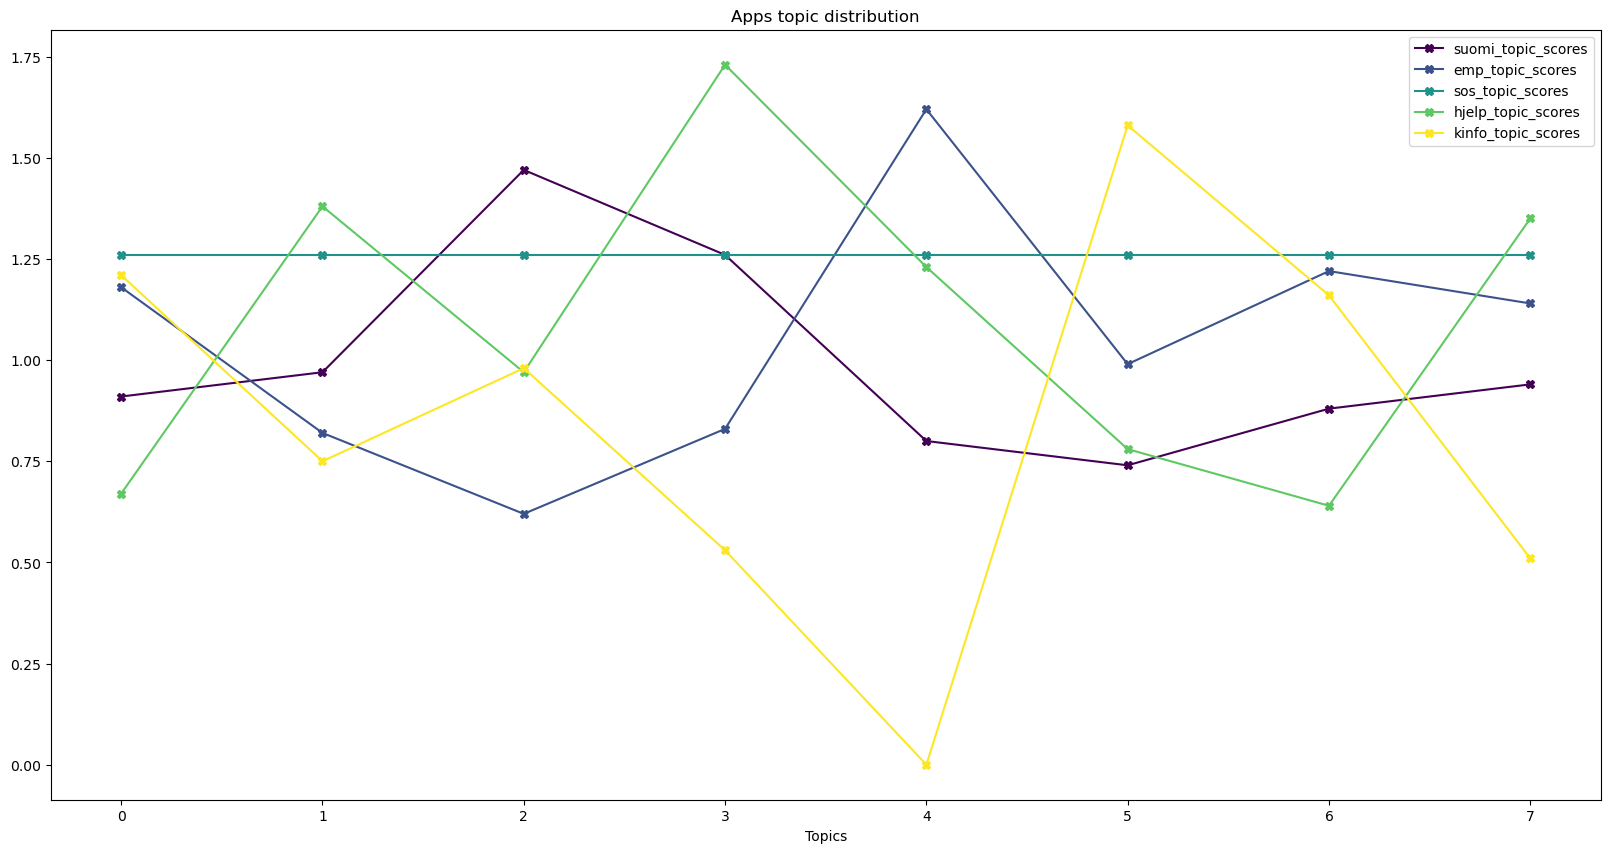

In [139]:
pos_topic_scores_df.plot(x='Topics', title = 'Apps topic distribution',colormap = 'viridis',figsize=(20,10), marker='X')

## Dominant Topics Negative Sentiment

In [141]:
neg_senti_df = df_dominant_topic[df_dominant_topic['senti']==-1]
neg_senti_df['app_name'].value_counts()

suomi    289
emp      251
sos      176
kinfo    109
hjelp     35
Name: app_name, dtype: int64

In [142]:
d_suomi = {}
for topic in list(neg_senti_df['Dominant_Topic'].unique()):
    number_of_reviews_for_suomi = neg_senti_df[neg_senti_df['app_name']=='suomi'].shape[0]
    number_of_total_reviews = neg_senti_df.shape[0]
    prob_of_topic_suomi = neg_senti_df[(neg_senti_df['app_name']=='suomi') & (neg_senti_df['Dominant_Topic']==topic)].shape[0]
    prob_of_topic_whole = neg_senti_df[neg_senti_df['Dominant_Topic']==topic].shape[0]
    suomi_topic_scores = ((1/number_of_reviews_for_suomi)*prob_of_topic_suomi)/((1/number_of_total_reviews)*prob_of_topic_whole)
    d_suomi[topic] = round(suomi_topic_scores,2)
d_suomi

{4: 0.68, 2: 0.54, 1: 1.14, 6: 1.13, 0: 0.76, 5: 1.17, 7: 0.91, 3: 0.9}

In [143]:
d_emp = {}
for topic in list(neg_senti_df['Dominant_Topic'].unique()):
    number_of_reviews_for_emp = neg_senti_df[neg_senti_df['app_name']=='emp'].shape[0]
    number_of_total_reviews = neg_senti_df.shape[0]
    prob_of_topic_emp = neg_senti_df[(neg_senti_df['app_name']=='emp') & (neg_senti_df['Dominant_Topic']==topic)].shape[0]
    prob_of_topic_whole = neg_senti_df[neg_senti_df['Dominant_Topic']==topic].shape[0]
    emp_topic_scores = ((1/number_of_reviews_for_emp)*prob_of_topic_emp)/((1/number_of_total_reviews)*prob_of_topic_whole)
    d_emp[topic] = round(emp_topic_scores,2)
d_emp

{4: 2.07, 2: 1.4, 1: 1.0, 6: 1.08, 0: 0.96, 5: 0.66, 7: 0.84, 3: 1.43}

In [144]:
d_sos = {}
for topic in list(neg_senti_df['Dominant_Topic'].unique()):
    number_of_reviews_for_sos = neg_senti_df[neg_senti_df['app_name']=='sos'].shape[0]
    number_of_total_reviews = neg_senti_df.shape[0]
    prob_of_topic_sos = neg_senti_df[(neg_senti_df['app_name']=='sos') & (neg_senti_df['Dominant_Topic']==topic)].shape[0]
    prob_of_topic_whole = neg_senti_df[neg_senti_df['Dominant_Topic']==topic].shape[0]
    sos_topic_scores = ((1/number_of_reviews_for_sos)*prob_of_topic_sos)/((1/number_of_total_reviews)*prob_of_topic_whole)
    d_sos[topic] = round(suomi_topic_scores,2)
d_sos

{4: 0.9, 2: 0.9, 1: 0.9, 6: 0.9, 0: 0.9, 5: 0.9, 7: 0.9, 3: 0.9}

In [145]:
d_hjelp = {}
for topic in list(neg_senti_df['Dominant_Topic'].unique()):
    number_of_reviews_for_hjelp = neg_senti_df[neg_senti_df['app_name']=='hjelp'].shape[0]
    number_of_total_reviews = neg_senti_df.shape[0]
    prob_of_topic_hjelp = neg_senti_df[(neg_senti_df['app_name']=='hjelp') & (neg_senti_df['Dominant_Topic']==topic)].shape[0]
    prob_of_topic_whole = neg_senti_df[neg_senti_df['Dominant_Topic']==topic].shape[0]
    hjelp_topic_scores = ((1/number_of_reviews_for_hjelp)*prob_of_topic_hjelp)/((1/number_of_total_reviews)*prob_of_topic_whole)
    d_hjelp[topic] = round(hjelp_topic_scores,2)
d_hjelp

{4: 2.05, 2: 1.12, 1: 1.19, 6: 1.26, 0: 0.42, 5: 0.65, 7: 0.75, 3: 2.29}

In [146]:
d_kinfo = {}
for topic in list(neg_senti_df['Dominant_Topic'].unique()):
    number_of_reviews_for_kinfo = neg_senti_df[neg_senti_df['app_name']=='kinfo'].shape[0]
    number_of_total_reviews = neg_senti_df.shape[0]
    prob_of_topic_kinfo = neg_senti_df[(neg_senti_df['app_name']=='kinfo') & (neg_senti_df['Dominant_Topic']==topic)].shape[0]
    prob_of_topic_whole = neg_senti_df[neg_senti_df['Dominant_Topic']==topic].shape[0]
    kinfo_topic_scores = ((1/number_of_reviews_for_kinfo)*prob_of_topic_kinfo)/((1/number_of_total_reviews)*prob_of_topic_whole)
    d_kinfo[topic] = round(kinfo_topic_scores,2)
d_kinfo

{4: 0.0, 2: 1.79, 1: 0.6, 6: 0.52, 0: 2.21, 5: 0.87, 7: 1.37, 3: 0.73}

In [147]:
neg_topic_scores_df = pd.DataFrame()
neg_topic_scores_df['Topics'] = d_suomi.keys()
neg_topic_scores_df['suomi_topic_scores'] = d_suomi.values()
neg_topic_scores_df['emp_topic_scores'] = d_emp.values()
neg_topic_scores_df['sos_topic_scores'] = d_sos.values()
neg_topic_scores_df['hjelp_topic_scores'] = d_hjelp.values()
neg_topic_scores_df['kinfo_topic_scores'] = d_kinfo.values()
neg_topic_scores_df['Topics'] = neg_topic_scores_df['Topics'].astype('int')
neg_topic_scores_df.sort_values('Topics',inplace=True)

<AxesSubplot:title={'center':'Apps topic distribution'}, xlabel='Topics'>

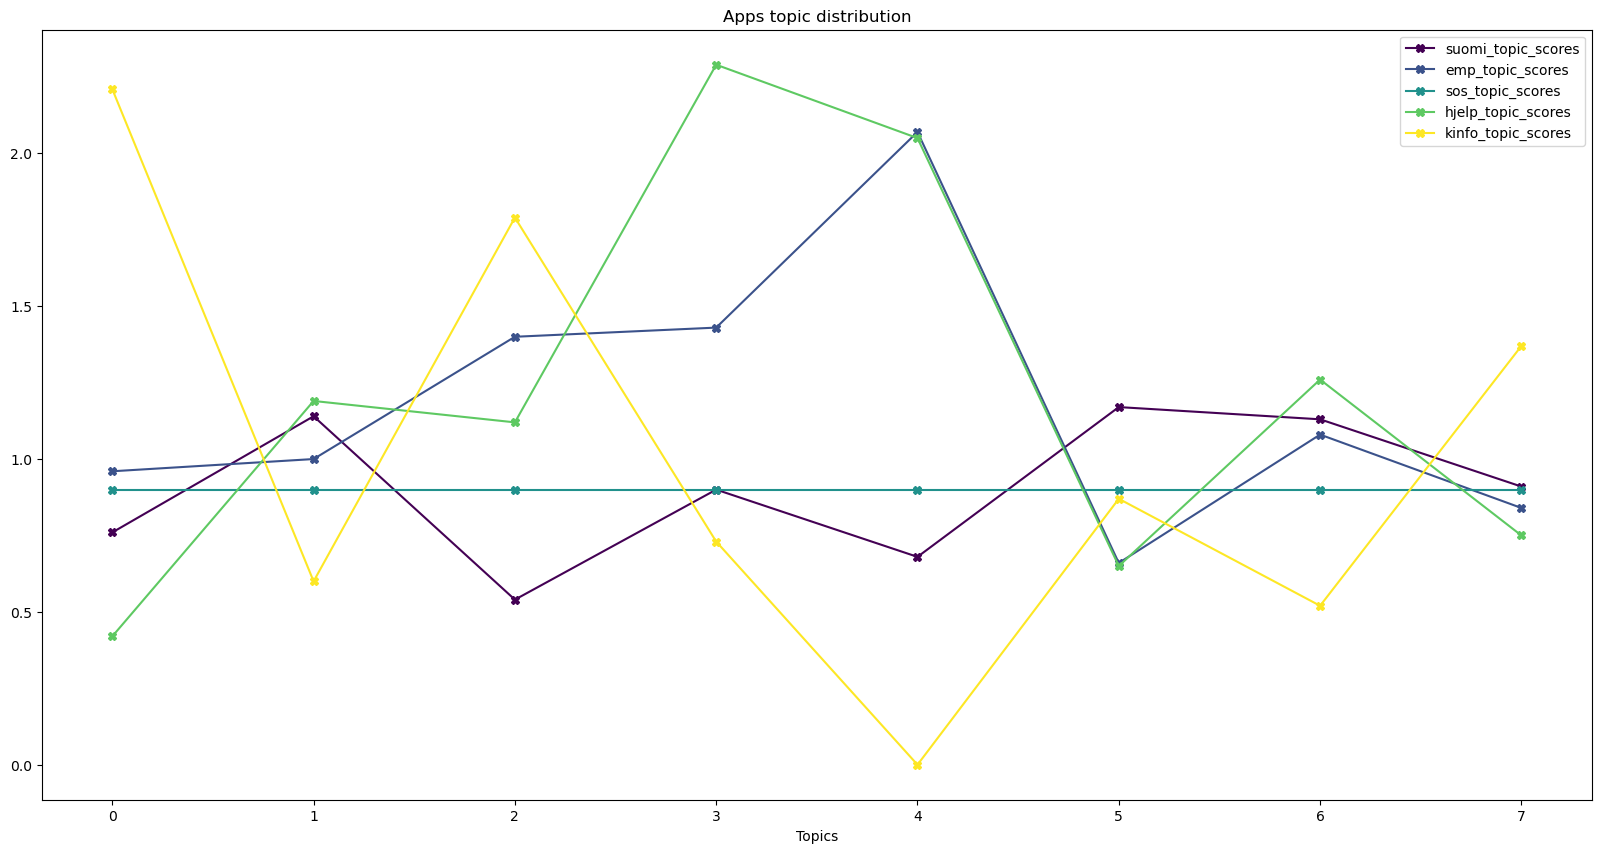

In [148]:
neg_topic_scores_df.plot(x='Topics', title = 'Apps topic distribution',colormap = 'viridis',figsize=(20,10), marker='X')

## Topics in the corpus
<br>
https://blog.hootsuite.com/social-media-crisis-communication/ <br>
Life saving application ------ Trust<br>
Updating the app features ------ Service<br>
Smart idea / innovative idea<br>
Location GPS tracing<br>
Emergency calling<br>
App necessity    <br>
Recommending app to use ------- Trust<br>  
Effect on device<br>
Notifying situation

<br>
https://www.omnilert.com/blog/6-critical-emergency-notification-management-app-features
<br>
Multi-modality: A wide range of communications methods to reach your community (Service)<br>
Reliability: Strong performance, even during concurrent communications (trust)<br>
Mobility: The ability to administer the system and interact with subscribers through an emergency app (Service)<br>
Usability: Simple setup and ease of use, user interface -- no software to install or maintain (functionality)<br>
Compatability: Effect of the apps on mobile or device performance (integration)<br>
Accuracy: Tracking the GPS location correctly (functionality)<br> 
Awareness: Notifying the users regarding the emergency situation (Service)

In [24]:
vis =PlottingResults(ldaModelDetailsTfAppWise[0][0], ldaModelDetailsTfAppWise[0][1], ldaModelDetailsTfAppWise[0][2])
vis

C:\Users\fuzel\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.272662 -0.260148       1        1  27.521777
7      0.272820  0.249356       2        1  20.738905
3     -0.116099 -0.112387       3        1  14.710239
2     -0.078696 -0.000942       4        1   9.045183
4     -0.097427 -0.007748       5        1   7.830248
0     -0.078241  0.066984       6        1   7.126730
5     -0.095716  0.035780       7        1   6.622265
6     -0.079303  0.029104       8        1   6.404652, topic_info=           Term        Freq       Total Category  logprob  loglift
1           app  533.000000  533.000000  Default  30.0000  30.0000
136       great  188.000000  188.000000  Default  29.0000  29.0000
14     location  215.000000  215.000000  Default  28.0000  28.0000
149       phone  151.000000  151.000000  Default  27.0000  27.0000
6     emergency  223.000000  223.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1506    station    5.184990    5.884765   Topic8  -4.9087   2.6215
311   extremely    4.589835    5.288544   Topic8  -5.0307   2.6064
79          fix   24.539369   33.757449   Topic8  -3.3542   2.4292
25         even    8.148420   31.929667   Topic8  -4.4567   1.3824
396       still    7.896286   34.299773   Topic8  -4.4881   1.2794

[313 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
291       5  0.899548   ability
54        1  0.977467      able
157       1  0.945001    access
1324      1  0.936101  accident
1098      1  0.927838  accuracy
...     ...       ...       ...
72        3  0.808674      word
72        6  0.184840      word
143       2  0.996695      work
22        1  0.982807     wrong
84        8  0.972201      year

[308 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 4, 3, 5, 1, 6, 7])

In [25]:
vis =PlottingResults(ldaModelDetailsTfIdfAppWise[0][0], ldaModelDetailsTfIdfAppWise[0][1], ldaModelDetailsTfIdfAppWise[0][2])
vis

C:\Users\fuzel\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.100341  0.089492       1        1  19.817643
7      0.078879 -0.054107       2        1  18.740896
3      0.044127 -0.046798       3        1  16.793144
6     -0.052950  0.087518       4        1  12.695373
5     -0.016815 -0.055227       5        1   9.101134
4     -0.041253  0.009073       6        1   8.799913
0     -0.045653 -0.026832       7        1   7.751311
2     -0.066676 -0.003119       8        1   6.300585, topic_info=          Term       Freq      Total Category  logprob  loglift
205       open  12.000000  12.000000  Default  30.0000  30.0000
190       save   6.000000   6.000000  Default  29.0000  29.0000
23   excellent   6.000000   6.000000  Default  28.0000  28.0000
188       life   6.000000   6.000000  Default  27.0000  27.0000
186  life_save   3.000000   3.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
515       keep   0.691959   5.636609   Topic8  -5.4749   0.6670
143       work   0.669134  14.518379   Topic8  -5.5084  -0.3127
16        need   0.660380  13.586591   Topic8  -5.5216  -0.2595
108       call   0.625863   7.636645   Topic8  -5.5753   0.2629
204      crash   0.615443   8.738343   Topic8  -5.5921   0.1114

[467 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
278       5  0.961627  accessibility
1324      1  0.345551       accident
1324      2  0.345551       accident
1324      7  0.345551       accident
486       1  0.330229       accurate
...     ...       ...            ...
22        3  0.305095          wrong
84        1  0.824640           year
1739      4  0.808255      yesterday
75        3  0.771145            yet
1004      5  0.830405          young

[605 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 4, 7, 6, 5, 1, 3])

In [26]:
vis =PlottingResults(ldaModelDetailsTfAppWise[1][0], ldaModelDetailsTfAppWise[1][1], ldaModelDetailsTfAppWise[1][2])
vis

C:\Users\fuzel\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.398538  0.028055       1        1  36.229482
1      0.045685 -0.342673       2        1  13.636183
7      0.062034  0.220038       3        1  13.462423
6     -0.096087  0.068567       4        1  11.207792
5     -0.106376 -0.010202       5        1   8.384370
0     -0.101705  0.001088       6        1   6.531473
2     -0.101744  0.026633       7        1   5.955911
4     -0.100345  0.008494       8        1   4.592366, topic_info=             Term        Freq       Total Category  logprob  loglift
247   application  731.000000  731.000000  Default  30.0000  30.0000
108          call  486.000000  486.000000  Default  29.0000  29.0000
544       program  301.000000  301.000000  Default  28.0000  28.0000
7            good  855.000000  855.000000  Default  27.0000  27.0000
149         phone  842.000000  842.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
962         saver    8.493601    9.583937   Topic8  -5.2115   2.9600
334    suggestion    8.049954    9.140996   Topic8  -5.2651   2.9537
1132    seriously    7.806610    8.897131   Topic8  -5.2958   2.9500
2382        honor    7.593408    8.688260   Topic8  -5.3235   2.9461
855        delete    8.141274   33.098187   Topic8  -5.2538   1.6782

[288 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
1144      6  0.954669       absolutely
157       4  0.826354           access
157       6  0.137726           access
1098      3  0.983176         accuracy
486       5  0.975632         accurate
...     ...       ...              ...
605       8  0.934529           wonder
143       1  0.156797             work
143       2  0.841978             work
274       5  0.962008            worth
2112      5  0.935637  worth_downloade

[270 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 8, 7, 6, 1, 3, 5])

In [27]:
vis =PlottingResults(ldaModelDetailsTfIdfAppWise[1][0], ldaModelDetailsTfIdfAppWise[1][1], ldaModelDetailsTfIdfAppWise[1][2])
vis

C:\Users\fuzel\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.032408  0.117554       1        1  26.945594
0      0.135595 -0.084966       2        1  18.595994
1      0.053488 -0.000610       3        1  15.917673
5     -0.028930  0.073524       4        1  15.489869
4     -0.098808  0.003981       5        1  12.547985
2     -0.093753 -0.109482       6        1  10.502885, topic_info=             Term        Freq       Total Category  logprob  loglift
7            good  146.000000  146.000000  Default  30.0000  30.0000
136         great   73.000000   73.000000  Default  29.0000  29.0000
379     important   39.000000   39.000000  Default  28.0000  28.0000
1047    necessary   28.000000   28.000000  Default  27.0000  27.0000
216        useful   39.000000   39.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
247   application    4.901971   59.189761   Topic6  -5.2044  -0.2376
16           need    4.364868   53.116756   Topic6  -5.3204  -0.2454
143          work    3.239165   78.659959   Topic6  -5.6187  -0.9363
7            good    3.224708  146.278058   Topic6  -5.6232  -1.5611
23      excellent    3.121764   26.842061   Topic6  -5.6556   0.1019

[372 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
1144      4  0.267828       absolutely
1144      6  0.669570       absolutely
1458      6  0.804474           accord
1098      1  0.228969         accuracy
1098      4  0.686906         accuracy
...     ...       ...              ...
2112      5  0.964695  worth_downloade
1473      3  0.647274       worthwhile
22        1  0.425725            wrong
22        4  0.532157            wrong
75        1  0.954494              yet

[661 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 6, 5, 3])

In [28]:
vis =PlottingResults(ldaModelDetailsTfAppWise[2][0], ldaModelDetailsTfAppWise[2][1], ldaModelDetailsTfAppWise[2][2])
vis

C:\Users\fuzel\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.448426  0.123422       1        1  37.969742
8      0.054229 -0.383044       2        1  10.882205
5      0.036196 -0.185318       3        1   8.640048
3     -0.033973  0.012952       4        1   6.405477
12    -0.041249  0.020892       5        1   5.857196
6     -0.052359  0.034901       6        1   5.810594
2     -0.046272  0.028410       7        1   5.101970
11    -0.026072  0.007013       8        1   4.729897
0     -0.028898  0.063549       9        1   4.164981
1     -0.083651  0.067602      10        1   3.060675
9     -0.080058  0.065523      11        1   2.730741
7     -0.065757  0.074762      12        1   2.497228
4     -0.080562  0.069336      13        1   2.149247, topic_info=            Term         Freq        Total Category  logprob  loglift
7           good  1469.000000  1469.000000  Default  30.0000  30.0000
1            app  3095.000000  3095.000000  Default  29.0000  29.0000
149        phone  1124.000000  1124.000000  Default  28.0000  28.0000
108         call   862.000000   862.000000  Default  27.0000  27.0000
143         work   952.000000   952.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2137        damn     0.118379     1.089586  Topic13  -9.3863   1.6204
1696       focus     0.113771     1.047377  Topic13  -9.4260   1.6202
3095   permanent     0.125464     2.163376  Topic13  -9.3282   0.9926
831   installing     0.112680     1.008934  Topic13  -9.4357   1.6480
2104   interpret     0.113607     1.085944  Topic13  -9.4275   1.5826

[429 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
54        1  0.994817        able
1144      3  0.984868  absolutely
157       5  0.987199      access
1324      9  0.989665    accident
48       13  0.971289      actual
...     ...       ...         ...
274      12  0.954311       worth
657       2  0.986103       write
22       13  0.994446       wrong
84       11  0.937975        year
75        8  0.980110         yet

[383 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 9, 6, 4, 13, 7, 3, 12, 1, 2, 10, 8, 5])

In [29]:
vis =PlottingResults(ldaModelDetailsTfIdfAppWise[2][0], ldaModelDetailsTfIdfAppWise[2][1], ldaModelDetailsTfIdfAppWise[2][2])
vis

C:\Users\fuzel\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.040509 -0.156729       1        1  16.006843
4      0.006492 -0.010379       2        1  11.888169
9     -0.199873 -0.044484       3        1  11.704450
2      0.096905  0.010626       4        1  11.346838
6     -0.072594  0.003821       5        1   9.444789
1      0.103659 -0.069280       6        1   9.229027
7      0.088833  0.084369       7        1   8.040371
5     -0.028901  0.170438       8        1   7.726513
8      0.002422  0.045660       9        1   7.564217
3     -0.037453 -0.034042      10        1   7.048782, topic_info=           Term        Freq       Total Category  logprob  loglift
7          good  274.000000  274.000000  Default  30.0000  30.0000
136       great  140.000000  140.000000  Default  29.0000  29.0000
1047  necessary   58.000000   58.000000  Default  28.0000  28.0000
216      useful   69.000000   69.000000  Default  27.0000  27.0000
205        open   90.000000   90.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
70      service    5.867119   48.158514  Topic10  -5.2731   0.5472
14     location    6.576720  112.754718  Topic10  -5.1589  -0.1894
108        call    6.010727   90.187578  Topic10  -5.2489  -0.0560
534        much    5.482207   31.633065  Topic10  -5.3409   0.8996
339         try    5.569144   47.735839  Topic10  -5.3252   0.5039

[615 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1144      2  0.155013  absolutely
1144      4  0.775066  absolutely
2155      1  0.826270      accept
1458      6  0.963291      accord
486       1  0.077952    accurate
...     ...       ...         ...
75        2  0.055064         yet
75        3  0.192723         yet
75        4  0.165191         yet
75        8  0.027532         yet
75       10  0.550637         yet

[1362 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 10, 3, 7, 2, 8, 6, 9, 4])

Problem with the hardware capabilities<br>
Demographics <br>
Recomended during emergencies <br>
Good app facilities <br>


In [30]:
topicsname=[]
num_topics =10
bigramDataWords = []
trigramDataWords = []
EvaluationResults =[]
appDetailInputsForLDA =[]
ldaModelDetailsTfAppWise =[]
ldaModelDetailsTfIdfAppWise =[]

In [14]:
apps = ['C:\\Users\\fuzel\\Documents\\Master Thesis\\Data_extraction\\emergencyplus.csv','C:\\Users\\fuzel\\Documents\\Master Thesis\\Data_extraction\\suomi112.csv','C:\\Users\\fuzel\\Documents\\Master Thesis\\Data_extraction\\sosalarm.csv']

for i in range(len(apps)):
    df = pd.read_csv(apps[i])
    reviewDataList = df['Review'].values.tolist()
    '''
    if i==0:
        numberOfTfTopics=8
        numberofTfIdfTopics=8
    elif i==1:
        numberOfTfTopics=8
        numberofTfIdfTopics=6
    else:
        numberOfTfTopics=13
        numberofTfIdfTopics=10
    '''
    numberOfTfTopics=4
    numberofTfIdfTopics=4
    
  #preprocessing using genism simple pre process
    reviewDataWords = list(PreProcessReviewData(reviewDataList))

  #stopword removal using nltk stop words
    reviewDataWordsWithoutStopWords = removeStopWords(reviewDataWords)

  # bigram trigram models
    bigram = gensim.models.Phrases(reviewDataWords, min_count=5, threshold=100)
    trigram = gensim.models.Phrases(bigram[reviewDataWords], threshold=100)

    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
  
  #creating bigram trigram models from the data set
    dataWordsWithbigrams = make_bigrams(reviewDataWordsWithoutStopWords)
    dataWordsWithTrigrams = make_trigrams(dataWordsWithbigrams)

  #lemmatizing data set
    lemmatizedData = lemmatization(dataWordsWithTrigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
 
  #create dictionary as the input for lda model
    id2word = corpora.Dictionary(lemmatizedData)
    
    # Create Corpus
    texts = lemmatizedData

  # create corpus with Term Document Frequency
    corpusTf = [id2word.doc2bow(text) for text in texts]

  #create corpus with tf-idf
    tfidf = gensim.models.TfidfModel(corpusTf)
    corpusTfidf = tfidf[corpusTf]
  
  #store details in dictionary for use later for evaluation
    dictionary = {'appName':apps[i],'id2word':id2word, 'lemmatized': lemmatizedData, 'tf' : corpusTf, 'tfIdf': corpusTfidf }
    appDetailInputsForLDA.append(dictionary)

    ldaModelTfDetails =[]
    ldaModelTfIdfDetails =[]

    ldaModelTf = TrainLdaModelWithTf(corpusTf, id2word, topics=numberOfTfTopics, passes=20)
    ldaModelTfWords = ldaModelTf.show_topics(num_topics=numberOfTfTopics, num_words=15,formatted=False)
    print("\nTopics obtained from the reviews of "+apps[i].split('\\')[-1]+ " - Tf Corpus")
    PrintTopicWords(ldaModelTfWords)   #Fig. 6 in report displays this result
  #pprint(ldaModelTf.print_topics()) -print with probabilities
    results = EvaluatePerformance(apps[i], corpusTf, ldaModelTf, corpusType = 'TF')
    EvaluationResults.append(results)

  #Store details to utilize when plotting graphs
    ldaModelTfDetails.append(ldaModelTf)
    ldaModelTfDetails.append(corpusTf)
    ldaModelTfDetails.append(id2word)
    ldaModelDetailsTfAppWise.append(ldaModelTfDetails)
    
    ldaModelTfIdf = TrainLdaModelWithTfIdf(corpusTfidf, id2word, topics=numberofTfIdfTopics, passes=20)
    ldaModelTIdffWords = ldaModelTfIdf.show_topics(num_topics=numberofTfIdfTopics, num_words=15,formatted=False)
    print("\nTopics obtained from the reviews of "+apps[i].split('\\')[-1]+ " - TfIdf Corpus")
    PrintTopicWords(ldaModelTIdffWords) #Fig. 6 in report displays this result
  #pprint(ldaModelTfIdf.print_topics()) -print with probabilities
    results = EvaluatePerformance(apps[i], corpusTfidf, ldaModelTfIdf, corpusType = 'TF-IDF')
    EvaluationResults.append(results)
  
  #Store details to utilize when plotting graphs
    ldaModelTfIdfDetails.append(ldaModelTfIdf)
    ldaModelTfIdfDetails.append(corpusTfidf)
    ldaModelTfIdfDetails.append(id2word)
    ldaModelDetailsTfIdfAppWise.append(ldaModelTfIdfDetails)

print (tabulate(EvaluationResults, headers=["App Name", "Corpus Type", "Perplexity", "Cv coherence score", "U mass Coherence score"]))


Topics obtained from the reviews of emergencyplus.csv - Tf Corpus
0::['try', 'life', 'save', 'map', 'information', 'love', 'police', 'line', 'poison', 'dial', 'available', 'problem', 'lot', 'nice', 'call']
1::['app', 'emergency', 'location', 'great', 'phone', 'need', 'address', 'work', 'good', 'gps', 'service', 'number', 'update', 'coordinate', 'find']
2::['look', 'however', 'read', 'excellent', 'concept', 'application', 'fantastic', 'handy', 'especially', 'much', 'see', 'ambulance', 'list', 'need', 'helpful']
3::['idea', 'people', 'word', 'close', 'road', 'keep', 'long', 'friend', 'take', 'locate', 'brilliant', 'many', 'useless', 'alert', 'situation']

Topics obtained from the reviews of emergencyplus.csv - TfIdf Corpus
0::['save', 'life', 'work', 'brilliant', 'problem', 'app', 'location', 'easy', 'house', 'emergency', 'call', 'operator', 'people', 'simple', 'make']
1::['great', 'app', 'emergency', 'location', 'need', 'phone', 'idea', 'address', 'gps', 'number', 'good', 'thank', 'rea

In [15]:
vis =PlottingResults(ldaModelDetailsTfAppWise[0][0], ldaModelDetailsTfAppWise[0][1], ldaModelDetailsTfAppWise[0][2])
vis

C:\Users\fuzel\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.329920 -0.002639       1        1  62.097256
3     -0.114355 -0.230627       2        1  13.624375
2     -0.098849  0.096432       3        1  13.481794
0     -0.116716  0.136834       4        1  10.796575, topic_info=             Term        Freq       Total Category  logprob  loglift
1             app  527.000000  527.000000  Default  30.0000  30.0000
11           idea   67.000000   67.000000  Default  29.0000  29.0000
6       emergency  238.000000  238.000000  Default  28.0000  28.0000
14       location  231.000000  231.000000  Default  27.0000  27.0000
339           try   36.000000   36.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
759         other    5.530034    6.164227   Topic4  -5.3665   2.1174
886           bit    5.638386    6.289100   Topic4  -5.3471   2.1167
171           map   23.378405   29.977787   Topic4  -3.9249   1.9773
1684  apple_watch    9.864475   11.939907   Topic4  -4.7878   2.0350
108          call    9.906894   67.481534   Topic4  -4.7835   0.3073

[173 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.991775  address
410       2  0.927647    alert
90        1  0.911236     also
90        2  0.034386     also
90        3  0.051579     also
...     ...       ...      ...
72        2  0.664537     word
72        3  0.047467     word
143       1  0.996271     work
22        1  0.991638    wrong
84        2  0.975221     year

[156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

In [16]:
vis =PlottingResults(ldaModelDetailsTfIdfAppWise[0][0], ldaModelDetailsTfIdfAppWise[0][1], ldaModelDetailsTfIdfAppWise[0][2])
vis

C:\Users\fuzel\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.064819 -0.048306       1        1  34.976630
3      0.032571  0.067712       2        1  31.677910
0     -0.048090 -0.025586       3        1  17.341949
2     -0.049300  0.006181       4        1  16.003511, topic_info=          Term      Freq      Total Category  logprob  loglift
190       save  6.000000   6.000000  Default  30.0000  30.0000
188       life  6.000000   6.000000  Default  29.0000  29.0000
23   excellent  6.000000   6.000000  Default  28.0000  28.0000
50   brilliant  4.000000   4.000000  Default  27.0000  27.0000
12        know  7.000000   7.000000  Default  26.0000  26.0000
..         ...       ...        ...      ...      ...      ...
205       open  1.641149  11.984636   Topic4  -5.5434  -0.1559
70     service  1.455597   8.802117   Topic4  -5.6634   0.0328
101     update  1.492554  10.425812   Topic4  -5.6383  -0.1114
90        also  1.190444   5.713249   Topic4  -5.8645   0.2639
6    emergency  1.257826  18.548974   Topic4  -5.8094  -0.8587

[261 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
54        1  0.726739     able
54        2  0.242246     able
157       1  0.270971   access
157       2  0.270971   access
157       4  0.270971   access
...     ...       ...      ...
143       4  0.146794     work
891       4  0.732348  working
274       2  0.545562    worth
22        1  0.295487    wrong
22        2  0.590975    wrong

[353 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3])

In [17]:
vis =PlottingResults(ldaModelDetailsTfAppWise[1][0], ldaModelDetailsTfAppWise[1][1], ldaModelDetailsTfAppWise[1][2])
vis

C:\Users\fuzel\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.352628 -0.043048       1        1  53.587199
1      0.071349  0.300200       2        1  20.771497
0      0.146399 -0.166183       3        1  14.606865
2      0.134879 -0.090969       4        1  11.034438, topic_info=              Term        Freq       Total Category  logprob  loglift
247    application  631.000000  631.000000  Default  30.0000  30.0000
544        program  330.000000  330.000000  Default  29.0000  29.0000
7             good  843.000000  843.000000  Default  28.0000  28.0000
190           save  218.000000  218.000000  Default  27.0000  27.0000
1              app  683.000000  683.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
814     especially   39.362098   52.389495   Topic4  -4.5546   1.9182
292          allow   21.444783   24.799055   Topic4  -5.1619   2.0588
98            take   39.799639  108.968935   Topic4  -4.5435   1.1969
2775  purposefully   25.712012   42.528998   Topic4  -4.9804   1.7009
2774         hello   21.412276   42.940382   Topic4  -5.1634   1.5083

[169 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
157       3  0.070353    access
157       4  0.914593    access
420       3  0.967489  addition
0         1  0.990062   address
292       3  0.120972     allow
...     ...       ...       ...
439       1  0.994993      user
47        4  0.987676   version
620       3  0.988084      want
185       1  0.990041      well
143       1  0.998277      work

[158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

In [18]:
vis =PlottingResults(ldaModelDetailsTfIdfAppWise[1][0], ldaModelDetailsTfIdfAppWise[1][1], ldaModelDetailsTfIdfAppWise[1][2])
vis

C:\Users\fuzel\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.044831  0.116521       1        1  39.717686
1     -0.137939 -0.098988       2        1  26.324531
0      0.035613  0.052451       3        1  19.088523
2      0.147157 -0.069984       4        1  14.869260, topic_info=           Term        Freq       Total Category  logprob  loglift
7          good  146.000000  146.000000  Default  30.0000  30.0000
136       great   72.000000   72.000000  Default  29.0000  29.0000
216      useful   38.000000   38.000000  Default  28.0000  28.0000
1047  necessary   29.000000   29.000000  Default  27.0000  27.0000
205        open   44.000000   44.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
296        make    5.597598   24.269695   Topic4  -5.4193   0.4390
486    accurate    4.494742   14.938594   Topic4  -5.6387   0.7048
1129     danger    3.441726    5.930864   Topic4  -5.9057   1.3617
102       thank    4.411488   24.079854   Topic4  -5.6574   0.2087
276      system    3.512530    7.332611   Topic4  -5.8853   1.1699

[244 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
291       1  0.928925          ability
1144      3  0.950864       absolutely
1458      3  0.817456           accord
486       1  0.401644         accurate
486       3  0.267763         accurate
...     ...       ...              ...
274       2  0.920262            worth
2112      2  0.857911  worth_downloade
22        1  0.942003            wrong
75        1  0.782223              yet
75        2  0.195556              yet

[345 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

In [20]:
vis =PlottingResults(ldaModelDetailsTfAppWise[2][0], ldaModelDetailsTfAppWise[2][1], ldaModelDetailsTfAppWise[2][2])
vis

C:\Users\fuzel\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.262384 -0.102244       1        1  30.495545
2     -0.011162 -0.204453       2        1  25.973169
3     -0.061414  0.332616       3        1  22.860040
0      0.334960 -0.025919       4        1  20.671246, topic_info=             Term         Freq        Total Category  logprob  loglift
7            good  1328.000000  1328.000000  Default  30.0000  30.0000
1             app  2632.000000  2632.000000  Default  29.0000  29.0000
108          call   827.000000   827.000000  Default  28.0000  28.0000
459  notification   965.000000   965.000000  Default  27.0000  27.0000
117           gps   836.000000   836.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
769   unnecessary    79.195854    80.023070   Topic4  -5.1442   1.5660
573           see   311.359397   342.195252   Topic4  -3.7751   1.4820
70        service   244.055813   293.913761   Topic4  -4.0187   1.3905
342       however   102.322811   148.703935   Topic4  -4.8879   1.2026
90           also   101.542318   328.513237   Topic4  -4.8956   0.4023

[177 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
54        3  0.996334      able
1324      2  0.993167  accident
1784      2  0.994679    active
353       4  0.990701       add
0         2  0.996980   address
...     ...       ...       ...
620       1  0.996983      want
20        4  0.998577       way
185       4  0.999424      well
143       1  0.999664      work
22        2  0.997367     wrong

[166 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

In [21]:
vis =PlottingResults(ldaModelDetailsTfIdfAppWise[2][0], ldaModelDetailsTfIdfAppWise[2][1], ldaModelDetailsTfIdfAppWise[2][2])
vis

C:\Users\fuzel\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.145986 -0.076703       1        1  28.546988
3     -0.024998  0.045542       2        1  25.340495
1      0.139061 -0.103175       3        1  24.842285
2      0.031924  0.134336       4        1  21.270232, topic_info=           Term        Freq       Total Category  logprob  loglift
7          good  288.000000  288.000000  Default  30.0000  30.0000
379   important   80.000000   80.000000  Default  29.0000  29.0000
216      useful   66.000000   66.000000  Default  28.0000  28.0000
1047  necessary   54.000000   54.000000  Default  27.0000  27.0000
23    excellent   45.000000   45.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
110        come    9.295253   36.978013   Topic4  -5.9174   0.1670
790      happen    9.254211   35.644030   Topic4  -5.9218   0.1994
277      really    9.665993   98.739540   Topic4  -5.8783  -0.7760
129         say    9.161432   39.463489   Topic4  -5.9319   0.0875
149       phone    9.215497  116.990202   Topic4  -5.9260  -0.9933

[272 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
1784      2  0.909971           active
0         1  0.034307          address
0         2  0.188690          address
0         3  0.583224          address
0         4  0.222997          address
...     ...       ...              ...
274       3  0.956844            worth
2112      4  0.943901  worth_downloade
22        2  0.085183            wrong
22        3  0.908616            wrong
75        3  0.994355              yet

[417 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])